In [1]:
import tensorflow as tf
#physical_devices = tf.config.list_physical_devices('GPU') 
#tf.config.experimental.set_memory_growth(physical_devices[0], True)
#tf.config.list_physical_devices(device_type=None)
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import models
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import h5py
from keras import callbacks 
from tensorflow.keras.layers import Input, concatenate,Dense
from keras.models import Sequential,Model
from keras.layers import Concatenate, Dense,Input, concatenate,Dropout,Flatten, Add
from sklearn.model_selection import KFold
from sklearn.utils import shuffle



In [2]:
#retrieve data
num = 4000 # number of profiles
nvza = 12 # number of channels
nsza=6

# get spatial dimension
fname = "D:\\Code\\Jupyter\\climate_project\\New Data\\profiles/profile_%05d.hdf5" %(1)
hf = h5py.File(fname, 'r')
spatial = hf.get('x') # HDF5 dataset "x": shape (4096,), type "<f8">
x = np.array(spatial) #change it to np array
x_size = np.size(np.array(spatial)) #4096; Dimension: (4096,)
hf.close()


In [3]:
# input and output dimensions
os = 1 # output slice size
halo=2
ts = 1+halo*2 # input slice size 
l2r=78
num=4000

In [4]:
#get the averaged reflectance from the dataset 
fname_r = "data_reflectance.h5"
hf_r = h5py.File(fname_r, 'r')
r=hf_r['dataset_reflectance']
r.shape

(4000, 82)

In [5]:
#get the averaged reflectance from the dataset 
fname_c = "data_cot.h5"
hf_c = h5py.File(fname_c, 'r')
c=hf_c['dataset_cot']
c.shape

(4000, 82)

In [6]:
c=c[:]
r=r[:]

r,c= shuffle(r, c, random_state=0)#Shuffle arrays in a consistent way.

#train test split
trp = 0.8; # 80 percent to train, includes validation
train_size=int(trp*num)
test_size = num - train_size #20% for testing:0.20*4000=800

print("train_size:",train_size,'profiles')
print("test_size:",test_size,'profiles')


train_size: 3200 profiles
test_size: 800 profiles


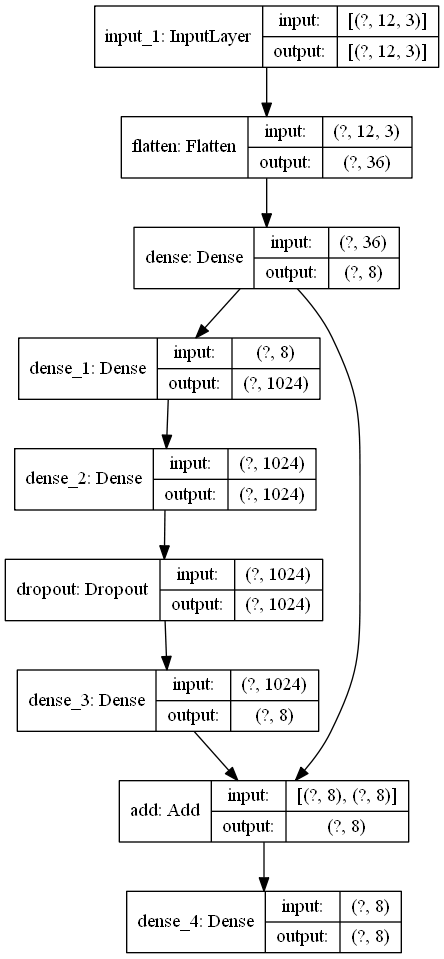

In [7]:
import keras

keras.utils.plot_model(model, show_shapes=True,show_layer_names=True,expand_nested=True,rankdir='TB')


In [19]:
#spatial slicing the 4000 profiles 

image=np.zeros((l2r*num,ts)) 
label=np.zeros((l2r*num,os)) 

#cut each profile into 4066 slices. 
#label: tau channel of the center of each slice(reduced domain)
for i in range(num):
    for n in range(l2r):
        img= r[i,n*os:n*os+ts] #input: 12 pixels for one slice, 3 channels 
        lb = c[i,n*os+halo:n*os+halo+os] #8 pixels for label,the tau channel is the label
        image[i*l2r+n]=img
        label[i*l2r+n]=lb 
print('whole dataset features size: ',image.shape,'whole dataset label size: ', label.shape) #4066*4000=16264000


whole dataset features size:  (312000, 5) whole dataset label size:  (312000, 1)


In [20]:
# DNN over domain ---------------------------------------------------------------------------------

def evaluate_model(train_image, test_image, train_label, test_label):
    
    
    input_img = Input(shape=(ts))
   # hn=Flatten()(input_img)
    hn = Dense(32, activation='relu')(input_img)#1st fully connected layer
    hn1 =Dense(1024, activation='relu')(hn)
    hn1=Dense(1024, activation='relu')(hn1)
    hn1=Dropout(0.2)(hn1)
    hn1=Dense(32, activation='relu')(hn1) #4th fully connected layer
    out_both=Add()([hn, hn1])
    hn2=Dense(os, activation='linear')(out_both)
    model = Model(input_img, outputs=[hn2])
    model.summary()
    
    
    
    ltype = 'mean_squared_error'
    ltype2=tf.keras.metrics.RootMeanSquaredError()
    bsize = 128
    eps = 4000

    model.compile(optimizer='adam',loss=ltype,metrics=[ltype,ltype2])

    earlystopping = callbacks.EarlyStopping(monitor ="val_loss",mode ="min", patience =25,restore_best_weights = True
                                            ,verbose=1) 
 
   # filepath="saved_models/checkpoint.hdf5"
   # checkpoint=tf.keras.callbacks.ModelCheckpoint(filepath=filepath,monitor="val_loss",verbose=1,save_best_only=True,mode='min')                                    
    
    history = model.fit(train_image,train_label,batch_size = bsize,epochs = eps,validation_split=0.125,callbacks =[earlystopping]) #validation set(10%)/trainset(80%)=0.125

    #The model that are best are loaded into the model    
 #   model_m.load_weights(filepath)


# test and predict ---------------------------------------------------------------------------------------
    print('test result')
    results = model.evaluate(test_image, test_label)
    predictions=model.predict(test_image)
    mse=results[1]
    rmse=results[2]
    
    return model_m,rmse,mse,history,predictions

In [24]:
#5-fold cross validation
n_folds=5

kf = KFold(n_splits=n_folds,random_state=None, shuffle=False)
print(kf.get_n_splits(r))
print(kf)
ratio=int(image.shape[0]/n_folds)

X_train=np.zeros((5,ratio*4,ts)) #train: 800*4  test:800
y_train=np.zeros((5,ratio*(n_folds-1),os))
X_test=np.zeros((n_folds,ratio,ts))
y_test=np.zeros((n_folds,ratio,os))

count=0
for train_index, test_index in kf.split(image):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train[count], X_test[count] = image[train_index], image[test_index] #r: radiance dataset
    y_train[count], y_test[count] = label[train_index], label[test_index] #c: cot dataset(label)
    count+=1

5
KFold(n_splits=5, random_state=None, shuffle=False)
TRAIN: [ 62400  62401  62402 ... 311997 311998 311999] TEST: [    0     1     2 ... 62397 62398 62399]
TRAIN: [     0      1      2 ... 311997 311998 311999] TEST: [ 62400  62401  62402 ... 124797 124798 124799]
TRAIN: [     0      1      2 ... 311997 311998 311999] TEST: [124800 124801 124802 ... 187197 187198 187199]
TRAIN: [     0      1      2 ... 311997 311998 311999] TEST: [187200 187201 187202 ... 249597 249598 249599]
TRAIN: [     0      1      2 ... 249597 249598 249599] TEST: [249600 249601 249602 ... 311997 311998 311999]


In [25]:
c# evaluate model----------------------------------------------------------------------------------------------
cv_scores = list()
cv_scores2 = list()

for n in range(n_folds):
        # split data    
    train_image, test_image, train_label, test_label = X_train[n],X_test[n],y_train[n],y_test[n]
        # evaluate model
    model,rmse,mse,history,predictions= evaluate_model(train_image, test_image, train_label, test_label)
    print('MSE on test set in fold'+str(n+1)+' : '+str(mse))
    print('RMSE on test set in fold'+str(n+1)+' : '+str(rmse))

    cv_scores.append(mse)
    cv_scores2.append(rmse)

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 5)]          0                                            
__________________________________________________________________________________________________
dense_20 (Dense)                (None, 32)           192         input_5[0][0]                    
__________________________________________________________________________________________________
dense_21 (Dense)                (None, 1024)         33792       dense_20[0][0]                   
__________________________________________________________________________________________________
dense_22 (Dense)                (None, 1024)         1049600     dense_21[0][0]                   
____________________________________________________________________________________________

1707/1707 [==============================] - 20s 11ms/step - loss: 1.6541 - mean_squared_error: 1.6541 - root_mean_squared_error: 1.4362 - val_loss: 1.5701 - val_mean_squared_error: 1.5701 - val_root_mean_squared_error: 1.4333
Epoch 27/4000
1707/1707 [==============================] - 19s 11ms/step - loss: 1.6496 - mean_squared_error: 1.6496 - root_mean_squared_error: 1.4307 - val_loss: 1.5242 - val_mean_squared_error: 1.5242 - val_root_mean_squared_error: 1.4279
Epoch 28/4000
1707/1707 [==============================] - 20s 12ms/step - loss: 1.6434 - mean_squared_error: 1.6434 - root_mean_squared_error: 1.4253 - val_loss: 1.7198 - val_mean_squared_error: 1.7198 - val_root_mean_squared_error: 1.4229
Epoch 29/4000
1707/1707 [==============================] - 20s 12ms/step - loss: 1.6385 - mean_squared_error: 1.6385 - root_mean_squared_error: 1.4205 - val_loss: 1.8032 - val_mean_squared_error: 1.8032 - val_root_mean_squared_error: 1.4184
Epoch 30/4000
1707/1707 [=========================

1707/1707 [==============================] - 19s 11ms/step - loss: 1.4572 - mean_squared_error: 1.4572 - root_mean_squared_error: 1.3293 - val_loss: 1.4925 - val_mean_squared_error: 1.4925 - val_root_mean_squared_error: 1.3283
Epoch 61/4000
1707/1707 [==============================] - 20s 12ms/step - loss: 1.4553 - mean_squared_error: 1.4553 - root_mean_squared_error: 1.3274 - val_loss: 1.3949 - val_mean_squared_error: 1.3949 - val_root_mean_squared_error: 1.3264
Epoch 62/4000
1707/1707 [==============================] - 20s 12ms/step - loss: 1.4455 - mean_squared_error: 1.4455 - root_mean_squared_error: 1.3254 - val_loss: 1.3646 - val_mean_squared_error: 1.3646 - val_root_mean_squared_error: 1.3245
Epoch 63/4000
1707/1707 [==============================] - 19s 11ms/step - loss: 1.4318 - mean_squared_error: 1.4318 - root_mean_squared_error: 1.3234 - val_loss: 1.4099 - val_mean_squared_error: 1.4099 - val_root_mean_squared_error: 1.3225
Epoch 64/4000
1707/1707 [=========================

KeyboardInterrupt: 

In [54]:
#quantitative result: average MSE on test set and its standard deviation
print('Estimated MSE on testset is %.4f with standard deviation (%.4f)' % (np.mean(cv_scores),np.std(cv_scores)))
print('MSE in five folds cross validation:',cv_scores)
print('Estimated RMSE on testset is %.4f with standard deviation (%.4f)' % (np.mean(cv_scores2),np.std(cv_scores2)))
print('RMSE in five folds cross validation:',cv_scores2)

Estimated MSE on testset is 7.2691 with standard deviation (0.1402)
MSE in five folds cross validation: [7.45725154876709, 7.210165023803711, 7.220712184906006, 7.0646796226501465, 7.392744541168213]
Estimated RMSE on testset is 3.1514 with standard deviation (0.0180)
RMSE in five folds cross validation: [3.1776883602142334, 3.1668736934661865, 3.1450772285461426, 3.136035680770874, 3.1311936378479004]


In [55]:
predictions.shape

(800, 82)

In [57]:
predict1=np.zeros((os)) #82
predict1=predictions[-3]
    
predict2=np.zeros((os))
predict2=predictions[-2]
    
predict3=np.zeros((os))
predict3=predictions[-1]

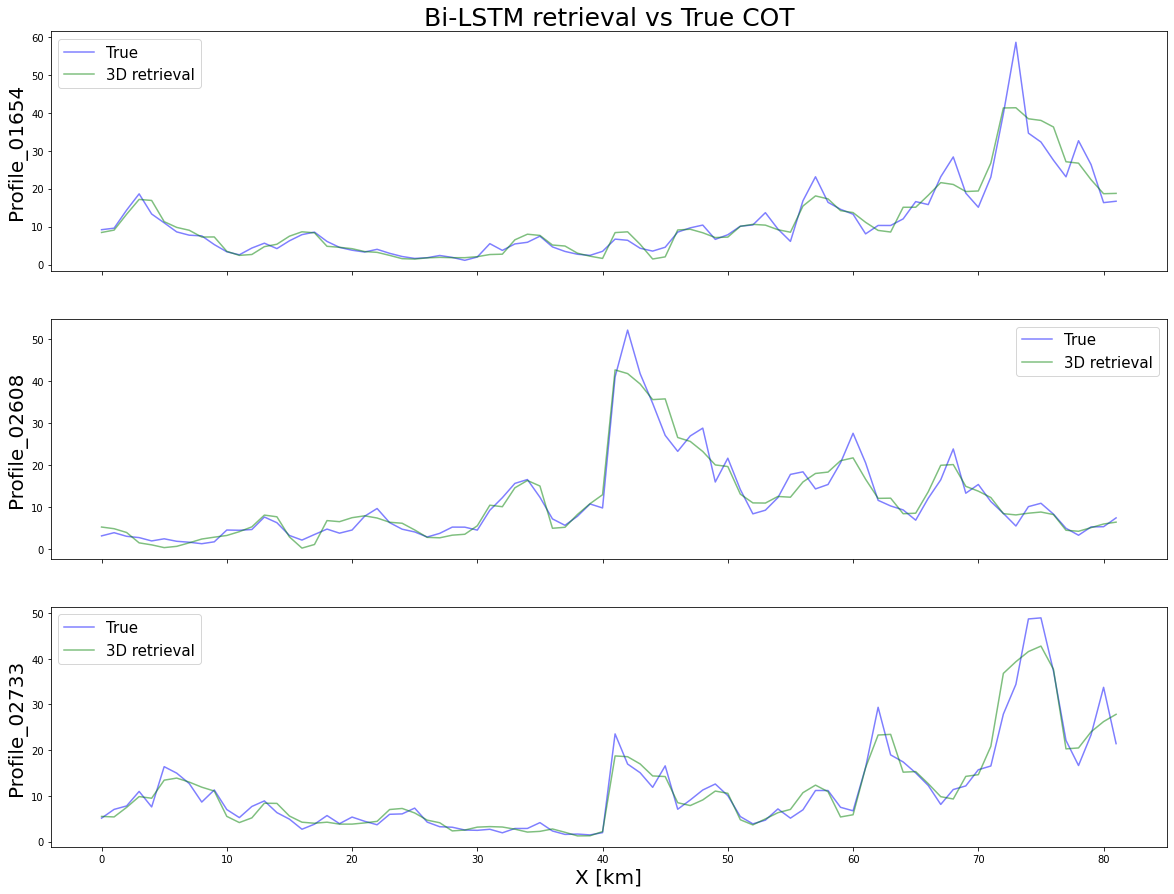

In [58]:
# plotting ---------------------------------------------------------------------------------------------------
fgnm = "plots/5folds_DNN2r SZA=60 VZA=0 "+"_"+str(len(history.history['val_loss'])-patience)+'_epochs'
fig, axs = plt.subplots(nrows=3,ncols=1,sharex=True,figsize=(20,15))

# plots the last three test profiles

#plot the third last profile
ax = axs[0]
ax.set_title(r"Bi-LSTM retrieval vs True COT", fontsize=25)
ax.plot(range(82),c[num-3],alpha=0.5,color="blue") #ground truth
ax.plot(range(82),predict1,alpha=0.5,color="green") 
ax.legend(["True", "3D retrieval"],fontsize=15)
ax.set_ylabel(r"Profile_01654",fontsize=20) 

#plot the second last profile
ax = axs[1]
ax.plot(range(82),c[num-2],alpha=0.5,color="blue")
ax.plot(range(82),predict2,alpha=0.5,color="green")
ax.legend(["True", "3D retrieval"],fontsize=15)
ax.set_ylabel(r"Profile_02608",fontsize=20)  

# plot the last profile
ax = axs[2]
ax.plot(range(82),c[num-1].T,alpha=0.5,color="blue")
ax.plot(range(82),predict3,alpha=0.5,color="green")
ax.legend(["True", "3D retrieval"],fontsize=15)
ax.set_ylabel(r"Profile_02733",fontsize=20)  
ax.set_xlabel('X [km]', fontsize=20)

plt.savefig(fgnm+".png",dpi=300,bbox_inches='tight')

# Plotting across predicted 82 COT values

In [63]:
std=[]
mean=[]

for k in range(os):#82
    tmp=[]
    for j in range(800): #test set
        tmp.append(np.abs(predictions[j][k]-test_label[j][k])) # RMSE and MSE
    std.append(np.std(tmp))
    mean.append(np.mean(tmp)) #### replace with RMSE 
    

std=np.array(std)
mean=np.array(mean)
std1 = np.std(mean)

# plot std, std1
# histogram of mean and histogram of std

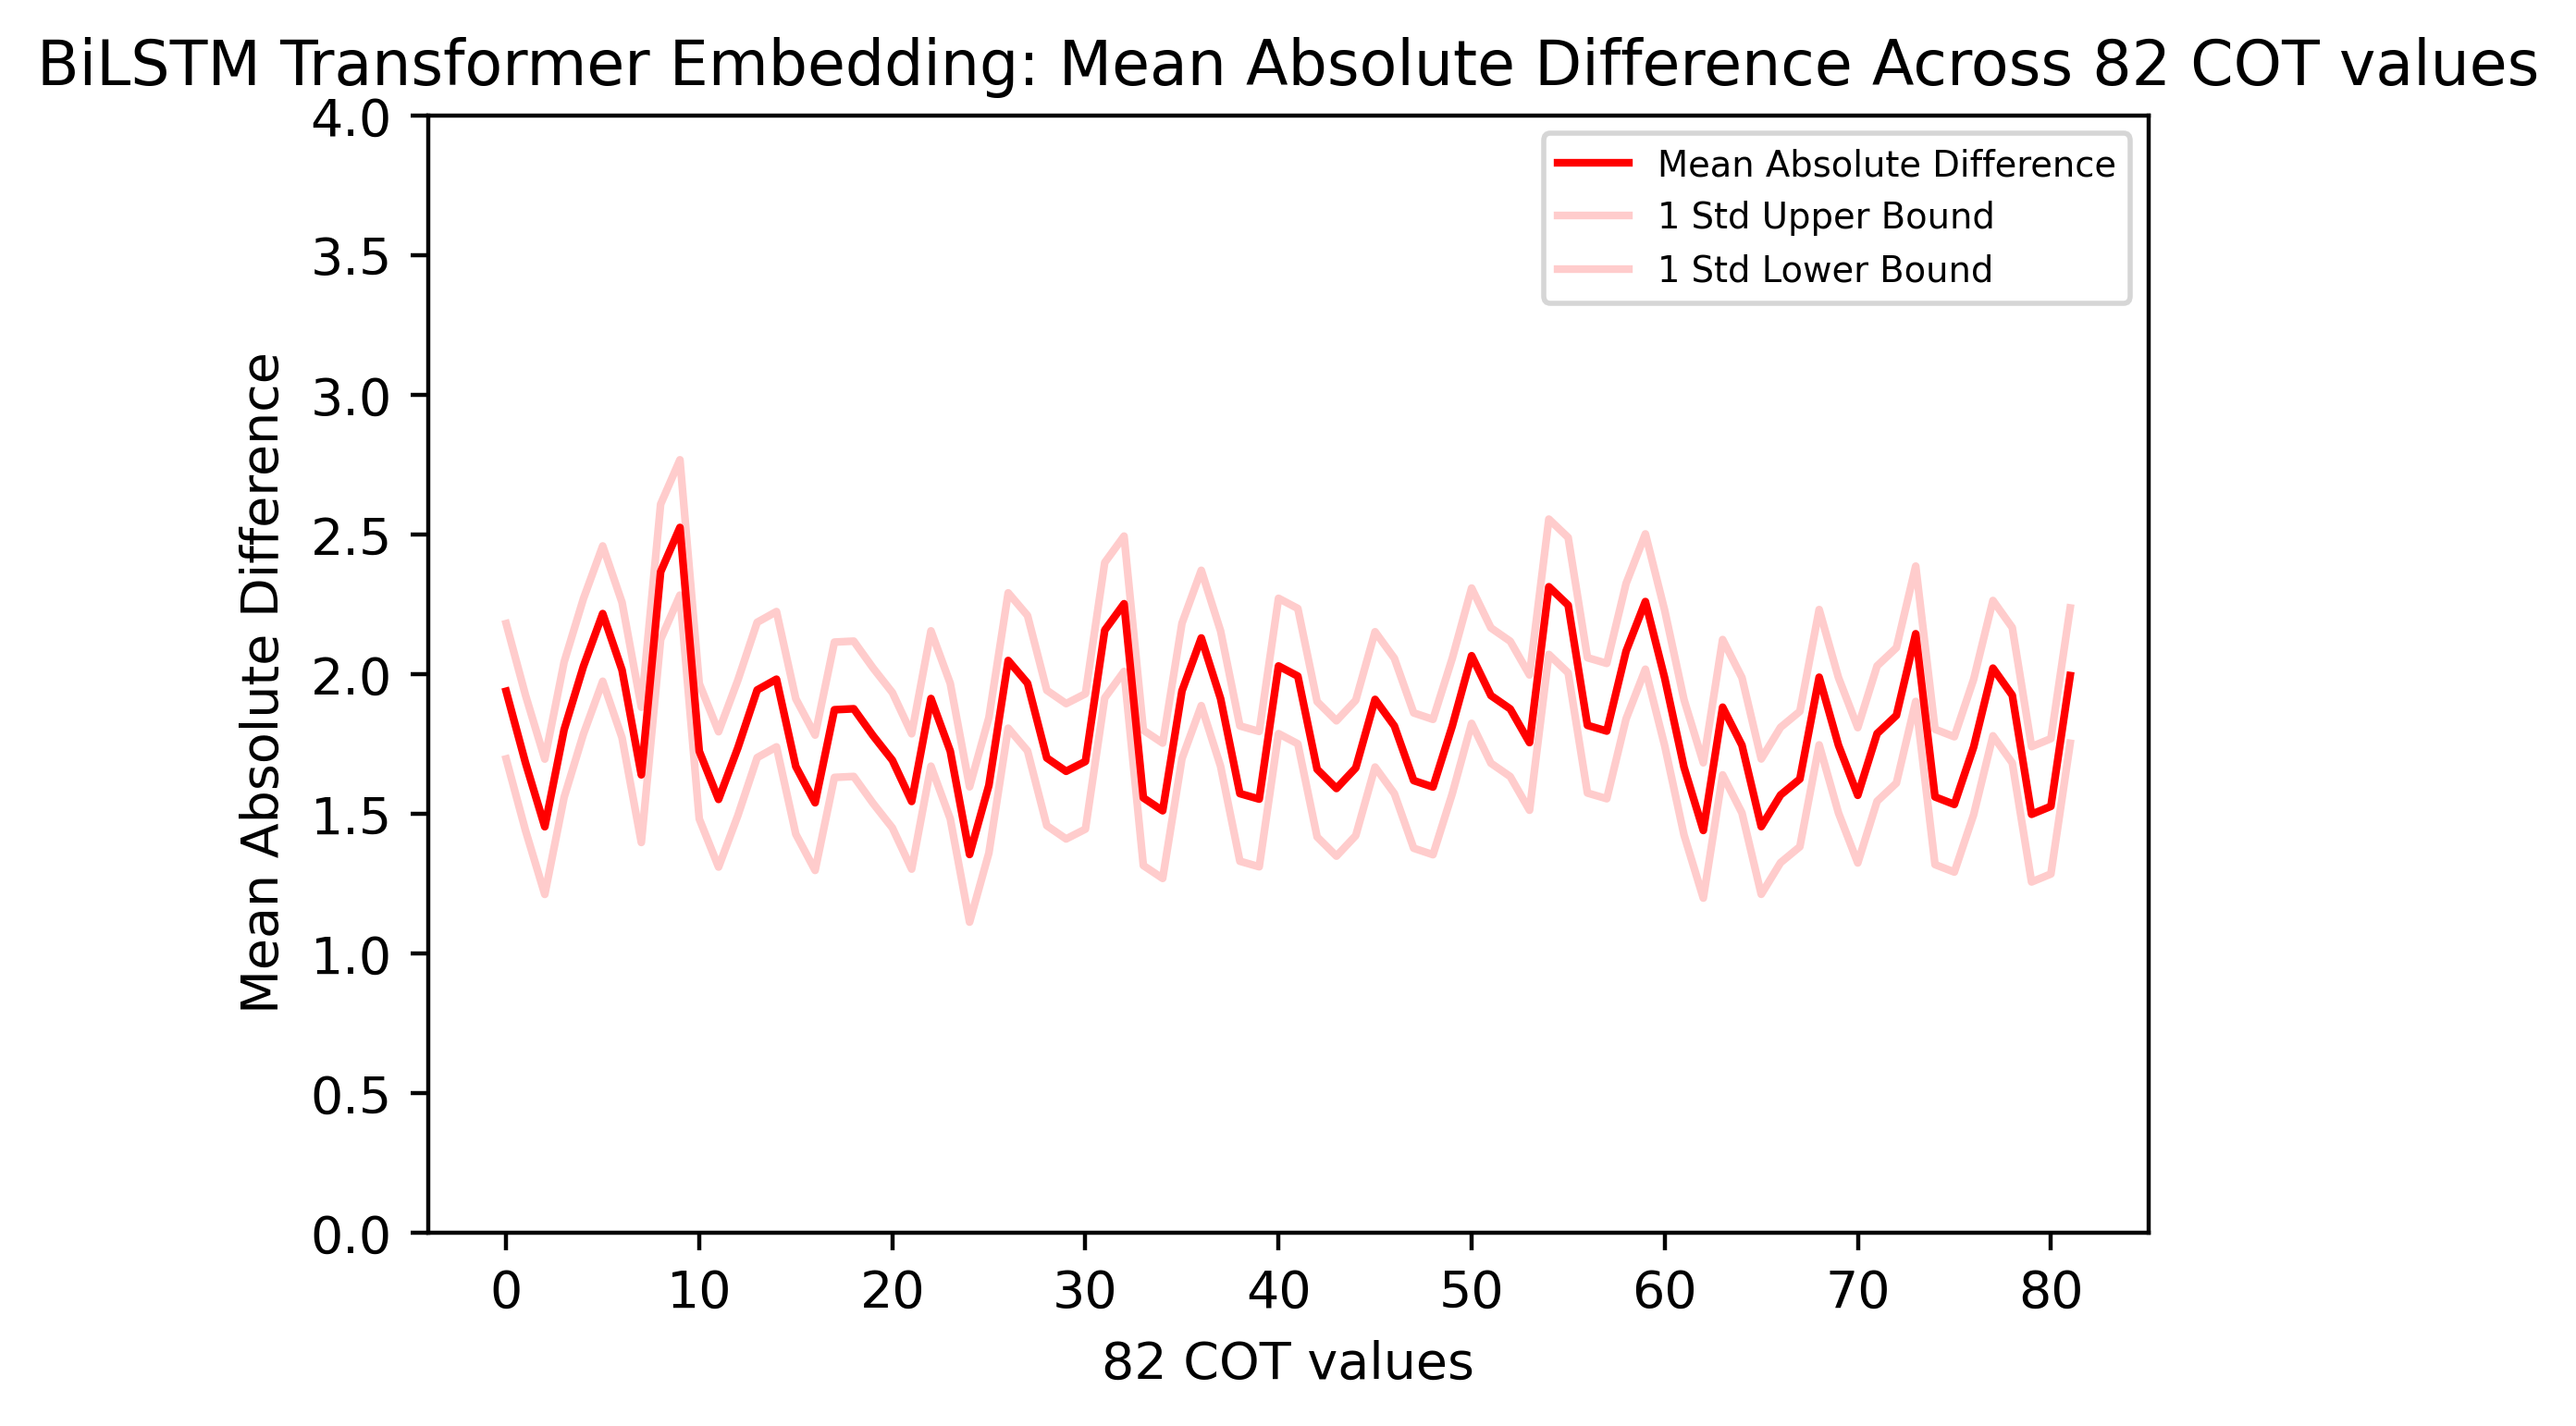

In [67]:
fig, ax = plt.subplots(dpi=400)
ax.plot(mean, '-r', label='Mean Absolute Difference')
ax.plot(mean+std1, '-r', label='1 Std Upper Bound',alpha=0.2)
ax.plot(mean-std1, '-r', label='1 Std Lower Bound',alpha=0.2)
ax.set_ylim((0,4))
ax.set_ylabel('Mean Absolute Difference ')  
ax.set_xlabel('82 COT values')

leg = ax.legend(loc=1,fontsize='x-small')
plt.title("BiLSTM Transformer Embedding: Mean Absolute Difference Across 82 COT values")

plt.savefig('plots/BiLSTM_with_ Transformer_Embedding_SZA=60_VZA=0_MeanAbsoluteDifferenceAcross82COTvalues.png',dpi=400)
